In [74]:
import lynx.kite
from lynx.kite import pp, text, subworkspace, WorkspaceParameter

In [75]:
lk = lynx.kite.LynxKite()

In [76]:
@lk.workspace(name='custom_boxes/one-step', parameters=[text('seed'), text('day')])
def one_step(input_graph):
    return (input_graph
        .addRandomVertexAttribute(
             name='cured_random', dist='Standard Uniform', seed=pp('${11223344 + seed.toInt}'))
        .deriveVertexAttribute(output='cured', expr='Math.max(cured, if (cured_random < 0.1) infected else 0)')
        .deriveVertexAttribute(output='infectious', expr='infected - cured')
        .aggregateOnNeighbors(direction='all neighbors', aggregate_infectious='sum')
        .fillVertexAttributesWithConstantDefaultValues(fill_neighborhood_infectious_sum='0')
        .addRandomVertexAttribute(name='infect_random', dist='Standard Uniform', seed=pp('${665544 + seed.toInt}'))
        .deriveVertexAttribute(
            expr='''
           val p = 1.0 - Math.pow(0.9, neighborhood_infectious_sum)
           Math.max(infected, if (infection_random < p) 1 else 0)''',
            output='infected')
        .deriveVertexAttribute(defined_attrs='false', output='infection_day', expr=pp('''val today: Option[Double] = if (infected.get > 0) Some($day) else None
infection_day.orElse(today)''')))

In [77]:
@lk.workspace(name='custom_boxes/big-component-only')
def big_component_only(input_graph):
    return (input_graph
        .findConnectedComponents()
        .filterByAttributes(apply_to_graph='.connected_components', filterva_size='>20000')
        .aggregateFromSegmentation(apply_to_graph='.connected_components', aggregate_id='count')
        .filterByAttributes(filterva_connected_components_id_count='1')
        .addReversedEdges()
        .mergeParallelEdges())

In [78]:
@lk.workspace(name='custom_boxes/simulate')
def sim(input_graph):
    state = (input_graph
      .addRandomVertexAttribute(dist='Standard Uniform', name='infection_random', seed='999777')
      .deriveVertexAttribute(output='infected', expr='if (infection_random < 0.001) 1.0 else 0.0')
      .addConstantVertexAttribute(value='0', name='cured')
      .deriveVertexAttribute(output='infection_day', expr='if (infected > 0) Some(0) else None'))
    for i in range(15):
        state = one_step(state, seed=str(i), day=str(i+1))
    return state

In [79]:
@lk.workspace(name='custom_boxes/evaluate')
def evaluate(sim_result):
    vis = sim_result.graphVisualization(state='{\"left\":{\"projectPath\":\"\",\"graphMode\":\"sampled\",\"display\":\"svg\",\"filters\":{\"vertex\":{},\"edge\":{}},\"bucketCount\":4,\"preciseBucketSizes\":false,\"relativeEdgeDensity\":false,\"axisOptions\":{\"vertex\":{},\"edge\":{}},\"sampleRadius\":1,\"attributeTitles\":{\"slider\":\"infection_day\"},\"animate\":{\"enabled\":false,\"style\":\"expand\",\"labelAttraction\":0},\"centers\":[\"127026020011224340\",\"663548610163526017\",\"817735316159868271\",\"971666669170605812\",\"1847406081303664676\"],\"customVisualizationFilters\":true,\"vertexColorMap\":\"Viridis\",\"labelColorMap\":\"Viridis\",\"edgeColorMap\":\"Viridis\",\"sliderColorMap\":\"Blue to orange\",\"lastCentersRequest\":{\"count\":5,\"filters\":[{\"attributeName\":\"infection_day\",\"valueSpec\":\"0\"}]},\"lastCentersResponse\":[\"127026020011224340\",\"663548610163526017\",\"817735316159868271\",\"971666669170605812\",\"1847406081303664676\"]},\"right\":{\"display\":\"svg\",\"filters\":{\"vertex\":{},\"edge\":{}},\"bucketCount\":4,\"preciseBucketSizes\":false,\"relativeEdgeDensity\":false,\"axisOptions\":{\"vertex\":{},\"edge\":{}},\"sampleRadius\":1,\"attributeTitles\":{},\"animate\":{\"enabled\":false,\"style\":\"expand\",\"labelAttraction\":0},\"centers\":[\"auto\"],\"customVisualizationFilters\":false,\"vertexColorMap\":\"Viridis\",\"labelColorMap\":\"Viridis\",\"edgeColorMap\":\"Viridis\",\"sliderColorMap\":\"Blue to orange\"}}')
    daily_data = sim_result.sql(
        '''select infection_day, count(User_ID) as count from vertices where infection_day is not null group by infection_day order by infection_day
''',
        persist='no')
    daily_plot = daily_data.customPlot(plot_code='''Vegas()
      .withData(table)
      .encodeX(\"infection_day\", Nom)
      .encodeY(\"count\", Quant)
      .mark(Bar)''')
    total = sim_result.sql('''select sum(infected) from vertices''')
    return {'graph': vis, 'daily_data': daily_data, 'daily_plot': daily_plot, 'total': total}

In [80]:
@lk.workspace(
    name='custom_boxes/drop-vertices',
    parameters=[WorkspaceParameter('attribute', 'vertex attribute (number)'), text('number_to_drop', '0')])
def drop_vertices(original):
    return (original
      .addRankAttribute(order='descending', keyattr=pp('$attribute'))
      .filterByAttributes(filterva_ranking=pp('>=$number_to_drop')))

In [81]:
@lk.workspace(
    name='custom_boxes/drop-edges',
    parameters=[WorkspaceParameter('attribute', 'edge attribute (number)'), text('number_to_drop', '0')])
def drop_edges(original):
    edge_ranking = lk.graphRejoin(
        original,
        original
          .takeEdgesAsVertices()
          .addRankAttribute(order='descending', rankattr='edge_ranking', keyattr=pp('edge_$attribute')),
        apply_to_target='!edges',
        attrs='edge_ranking')
    return edge_ranking.filterByAttributes(filterea_edge_ranking=pp('>=$number_to_drop'))

In [82]:
graph = big_component_only(lk.importSnapshot(path='PokecGraph'))
with_attributes = (graph
  .computePageRank(direction='all edges')
  .addRandomVertexAttribute(dist='Standard Uniform', seed='42')
  .computeDegree()
  .addRandomEdgeAttribute(dist='Standard Uniform', seed='43')
  .computeDispersion()
  .deriveEdgeAttribute(output='endpoint_degree_sum', expr='src$degree + dst$degree')
  .deriveEdgeAttribute(output='endpoint_degree_product', expr='src$degree * dst$degree')
  .discardVertexAttributes(name='Age,Gender,Last_Login_Days,Region,Registration_Days,connected_components_id_count')
  .discardEdgeAttributes(name='normalized_dispersion')
)

vertices_kept = drop_vertices(with_attributes, attribute='random', number_to_drop='0').discardEdges()
edges_kept = drop_edges(with_attributes, attribute='random', number_to_drop='0')

reconstructed = lk.graphRejoin(vertices_kept, edges_kept, edge='yes')

drop_statistics = lk.sql2(with_attributes, reconstructed, sql='''select `one.graph_attributes`.`!vertex_count` - `two.graph_attributes`.`!vertex_count` as `Vertices Dropped`, `one.graph_attributes`.`!edge_count` - `two.graph_attributes`.`!edge_count` as `Edges Dropped` from `one.graph_attributes` CROSS JOIN `two.graph_attributes`
''')

sim_result = sim(reconstructed)

on_original = lk.graphRejoin(graph, sim_result, attrs='infection_day,infected')

evaluation = evaluate(on_original)

res = [evaluation, drop_statistics]


In [84]:
ws = lynx.kite.Workspace(name='Infection Modeling', terminal_boxes=res)
ws.save("")

'Infection Modeling'

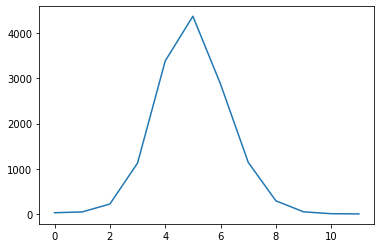

In [71]:
evaluation['daily_data'].df()['count'].plot()